# Take-home Assignment
## Yosi Levi, Data Scientist

# Table of Contents
1. [Import libraries](#sec1)
2. [Task 1](#sec2)
    * [2.1. Read the NRRD file](#sec2.1)
    * [2.2 Display few slices of the nrrd file](#sec2.2)
    * [2.3 Display the JPEG image using PIL](#sec2.3)
    * [2.4 Display the JPEG image using cv2](#sec2.4)
    * [2.5 Code summary for task 1](#sec2.5)
    * [2.6 Find match](#sec2.6)
    * [2.7 Display results](#sec2.6)
3. [Task 2](#sec3)
    * [3.1. Display few planes image within a fetal brain from training set](#sec3.1)
    * [3.2 Loading data, preprocessing and create data loaders](#sec3.2)
    * [3.3 Creating a Basic CNN Architecture](#sec3.3)
    * [3.4 Training and testing a model](#sec3.4)
    * [3.5 Plot training and testing losses](#sec3.5)
    * [3.6 Creating a ResNet-based architecture model](#sec3.6)
    * [3.7 Training and testing a model](#sec3.7)
    * [3.8 Plot training and testing losses](#sec3.8)
4. [References](#sec4)


<a id="sec1"></a>
# [1. Load library's](#sec1)

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import StandardScaler, OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, cross_val_predict, train_test_split, GridSearchCV, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet, ARDRegression, BayesianRidge
from sklearn.metrics import  r2_score, mean_absolute_error, mean_squared_error, classification_report, confusion_matrix, accuracy_score, classification_report, auc
from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostClassifier
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import VotingRegressor
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
sns.set_palette("Set2")
import nrrd
from skimage.metrics import structural_similarity as ssim
import cv2
import os
from PIL import Image
from skimage import exposure
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


<a id="sec2"></a>
# [2. Task 1](#sec2)
The goal of this task is to create a "semi-norm" function for measuring similarity between pairs of images. Specifi cally, given a JPEG image and a 3D NRRD fi le, the task is to identify the most similar image contained in the NRRD fi le. The required similarity function ("semi-norm") should allow for minor (+-10%) changes in scaling, rotation, and translation. In addition, it should take into account possible changes in the brightness of the image.

<a id='sec2.1'></a>
### [2.1. Read the NRRD file](#sec2.1)

In [2]:
nrrd_path = "/home/yosi/Projects/TakeHomeAssignment/Task1/task1.nrrd"
data, header = nrrd.read(nrrd_path)

# Print the shape of the data array and the header information
print("Data Shape:", data.shape)
print("Header Information:", header)

Data Shape: (256, 256, 112)
Header Information: OrderedDict([('type', 'short'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([256, 256, 112])), ('space directions', array([[0.9375, 0.    , 0.    ],
       [0.    , 0.9375, 0.    ],
       [0.    , 0.    , 1.4   ]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-119.531, -119.531,  -77.7  ]))])


<a id='sec2.2'></a>
### [2.2. Display few slices of the nrrd file](#sec2.2)

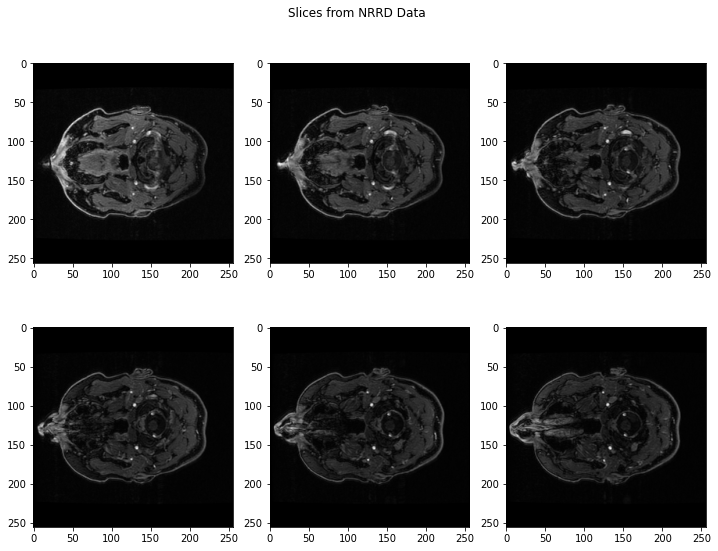

In [3]:
plt.figure(figsize=(10,8))
plt.suptitle('Slices from NRRD Data')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(data[:, :, i], cmap='gray')
plt.tight_layout()
plt.show()

<a id='sec2.3'></a>
### [2.3. Display the JPEG image using PIL](#sec2.3)

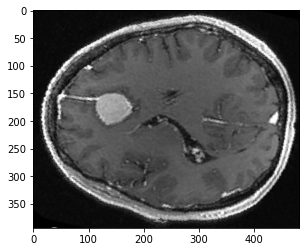

In [4]:
jpeg_path = "/home/yosi/Projects/TakeHomeAssignment/Task1/task1.jpg"
image = Image.open(jpeg_path)
# Display the image
plt.imshow(image)
plt.show()

<a id='sec2.4'></a>
### [2.4. Display the JPEG image using cv2](#sec2.4)

Shape: (394, 482, 3)


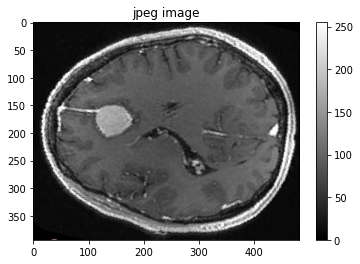

In [5]:
# Load the image
image = cv2.imread(jpeg_path)
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('Shape:',image.shape)
# Display the image
plt.imshow(image, cmap='gray')  # Adjust the slicing as necessary
plt.colorbar()
plt.title('jpeg image')
plt.show()

Shape: (394, 482)


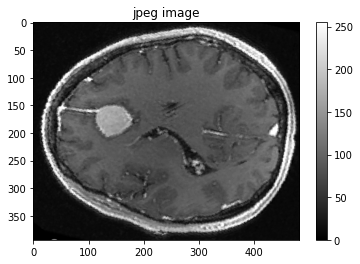

In [6]:
# Load the image
image = cv2.imread(jpeg_path)
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print('Shape:',image.shape)
# Display the image
plt.imshow(image, cmap='gray')  # Adjust the slicing as necessary
plt.colorbar()
plt.title('jpeg image')
plt.show()

<a id='sec2.5'></a>
### [2.5. Code summary for task 1](#sec2.5)

The following code performs a series of preprocessing and comparison steps to identify the most similar NRRD image slice to a given JPEG image. In the next step, we will apply the following steps to find the best match:

1. **Loading and Preprocessing JPEG Image**:
   - `load_image`: Loads a JPEG image, converts it to grayscale, and returns the processed image.

2. **Loading NRRD Images**:
   - `load_nrrd_images`: Loads images from a NRRD file, returning the image data.

3. **Preprocessing Image (for Brightness Normalization)**:
   - `preprocess_image`: Normalizes image brightness and scales intensity values to the range (0, 255), returning the normalized image.

4. **Adjusting Image Gamma**:
   - `adjust_gamma`: Applies gamma correction to adjust the brightness, helping match image brightness levels.

5. **Resizing Images**:
   - `resize_image`: Resizes the given image to a target size using interpolation to standardize image dimensions.

6. **Calculating Structural Similarity (SSIM)**:
   - `similarity`: Computes SSIM (Structural Similarity Index) between two images to quantify similarity.

7. **Finding the Most Similar Image**:
   - `find_most_similar_image`: This function does the following:
     - Loads and preprocesses a JPEG image, resizing it to 256x256 pixels and adjusting gamma.
     - Loads images from a NRRD file and iterates through each slice.
     - For each NRRD slice, it preprocesses, resizes, and compares it to the JPEG image using SSIM.
     - Tracks the slice with the highest similarity score, returning this best-matching image, its SSIM score, and the slice index (`frame_id`).


In [7]:
def load_image(path):
    """Load and preprocess the JPEG image."""
    image = cv2.imread(path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image_gray


def load_nrrd_images(path):
    """Load images from NRRD file."""
    data, _ = nrrd.read(path)
    return data


def preprocess_image(image):
    """Normalize brightness and scale the image."""
    image_rescaled = exposure.rescale_intensity(image, in_range='image', out_range=(0, 255))
    return image_rescaled.astype(np.uint8)


def adjust_gamma(image, gamma=1.0):
    """Adjust the gamma of the image for changes brightness between the images."""
    inv_gamma = 1.0 / gamma
    # Apply gamma correction
    adjusted = np.power(image / 255.0, inv_gamma) * 255.0
    return adjusted.astype(np.uint8)


def resize_image(image, target_size):
    """Resize image to target size directly."""
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized_image


def similarity(image1, image2):
    """Calculate similarity between two images using SSIM."""
    return ssim(image1, image2)


def find_most_similar_image(jpeg_path, nrrd_path):

    """Find the most similar image in a NRRD file to a JPEG image."""
    jpeg_image = load_image(jpeg_path)
    jpeg_image = cv2.resize(jpeg_image,  (256, 256), interpolation=cv2.INTER_AREA)

    jpeg_image = adjust_gamma(jpeg_image)

    # Get dimensions of the JPEG image
    jpeg_height, jpeg_width = jpeg_image.shape

    nrrd_images = load_nrrd_images(nrrd_path)

    best_score = -1
    best_image = None

    # loop through the nrrd images
    for z in range(nrrd_images.shape[2]):
        #print(f"check frame number:{z}")
        nrrd_image = nrrd_images[:,:,z]
        nrrd_image_preprocessed = adjust_gamma(nrrd_image)

        # Resize the NRRD image to match the JPEG image size directly
        nrrd_image_resized = resize_image(nrrd_image_preprocessed, (jpeg_width, jpeg_height))

        # Calculate similarity
        score = similarity(jpeg_image, nrrd_image_resized)

        if score > best_score:
            best_score = score
            best_image = nrrd_image
            frame_id = z

    return best_image, best_score, frame_id


<a id='sec2.6'></a>
### [2.5. Find match](#sec2.6)

In [8]:
jpeg_path = "/home/yosi/Projects/TakeHomeAssignment/Task1/task1.jpg" # define path for jpeg image
nrrd_path = "/home/yosi/Projects/TakeHomeAssignment/Task1/task1.nrrd" # define path for nrrd file

best_image, score, frame_id = find_most_similar_image(jpeg_path, nrrd_path)

<a id='sec2.7'></a>
### [2.7. Display results](#sec2.7)

Best similarity score: 0.17565815626193845
frame_id: 68


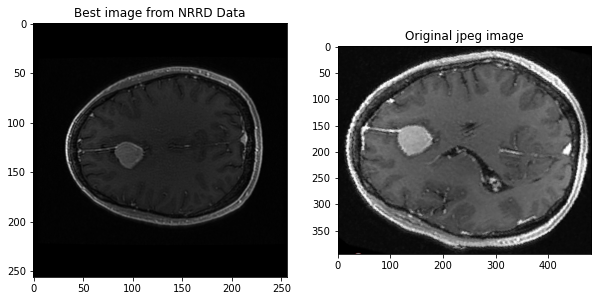

In [9]:
plt.figure(figsize=(10,8))
print(f"Best similarity score: {score}")
print(f"frame_id: {frame_id}")
plt.subplot(1,2,1)
plt.imshow(best_image, cmap='gray')  # Adjust the slicing as necessary
plt.title('Best image from NRRD Data')
plt.subplot(1,2,2)
image = Image.open(jpeg_path)
# Display the image
plt.imshow(image)
plt.title('Original jpeg image')
plt.show()

<a id="sec1"></a>
# [3. Task 2](#sec3)
The objective of this task is to develop an AI model that can accurately predict 3D plane coordinates from an image.

#### Dataset Overview
- **Images and Labels**: The dataset consists of images and corresponding labels, divided into training and test sets.
- **Plane Representation**: Each image depicts a specific plane within a fetal brain, and each plane has an associated 3D coordinate label normalized to the brain's volume dimensions.

#### 3D Coordinate Labels
- **Coordinate Structure**: Each plane is represented by a 9-point vector, defined by three 3D points:
  - **Up**: (x1, y1, z1)
  - **Left**: (x2, y2, z2)
  - **Right**: (x3, y3, z3)

These coordinates will serve as the target outputs for the model, allowing it to position each plane in 3D space.


<a id='sec3.1'></a>
### [3.1. Display few planes image within a fetal brain from training set](#sec3.1)

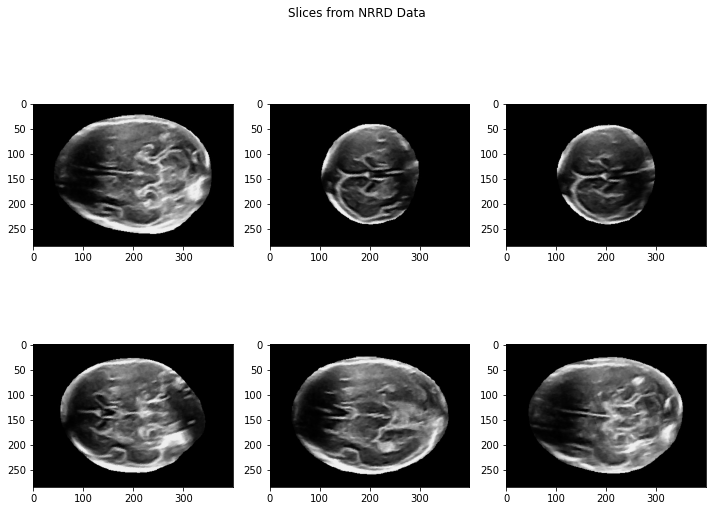

(285, 400, 3)

In [10]:
# Define directories
image_dir = "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/train/images/"
label_dir = "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/train/labels/"
plt.figure(figsize=(10,8))
plt.suptitle('Slices from NRRD Data')
for i in range(6):
    img_name = sorted(os.listdir(image_dir))[i]
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(2,3,i+1)
    plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()
image.shape

<a id='sec3.2'></a>
### [3.2. Loading data, preprocessing and create data loaders](#sec3.2)

In [23]:
def create_dataloader(image_dir, label_dir, batch_size=32, image_size=(224, 224)):

    # Custom transformation for ultrasound images
    transform = transforms.Compose([
        transforms.Resize(image_size),  # Resize images to 224x224
        transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Adjust brightness/contrast
        transforms.ToTensor(),  # Convert to tensor
    ])
    
    # Initialize lists to store data
    images = []
    labels = []
    
    # Load images and labels
    for img_name in sorted(os.listdir(image_dir)):
        # Load and preprocess the image
        img_path = os.path.join(image_dir, img_name)
        image = Image.open(img_path).convert("RGB") # .convert("L")
        image = transform(image)  # Apply transformations
        images.append(image)

        # Load corresponding label
        label_name = img_name.replace('.jpg', '.txt')  # Adjust extension if necessary
        label_path = os.path.join(label_dir, label_name)
        # Read the CSV file (assuming it has no headers)
        df = pd.read_csv(label_path, header=None)
        # Convert the first row (or the desired row) into a tensor
        label = torch.tensor(df.iloc[0].values, dtype=torch.float32)  # Change 0 to the appropriate row index if needed
        labels.append(label)
    
    # Convert lists to tensors
    images = torch.stack(images)
    labels = torch.stack(labels)

    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    return dataloader


In [24]:
image_dir_train = "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/train/images/"
label_dir_train = "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/train/labels/"

image_dir_test= "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/test/images/"
label_dir_test = "/home/yosi/Projects/TakeHomeAssignment/Task2/dataset_v17 2/dataset_v17 2/test/labels/"

train_loader = create_dataloader(image_dir_train, label_dir_train, batch_size=32)
test_loader = create_dataloader(image_dir_test, label_dir_test, batch_size=32)

In [25]:
# Example of iterating through the DataLoader
for batch_images, batch_labels in test_loader:
    print(batch_images.shape)  # [batch_size, 3, 224, 224]
    print(batch_labels.shape)  # [batch_size]

torch.Size([32, 3, 224, 224])
torch.Size([32, 9])
torch.Size([32, 3, 224, 224])
torch.Size([32, 9])
torch.Size([32, 3, 224, 224])
torch.Size([32, 9])
torch.Size([32, 3, 224, 224])
torch.Size([32, 9])
torch.Size([32, 3, 224, 224])
torch.Size([32, 9])
torch.Size([16, 3, 224, 224])
torch.Size([16, 9])


<a id='sec3.3'></a>
### [3.3. Creating a Basic CNN Architecture](#sec3.3)

In [26]:
class PlaneCoordinatePredictorCNN(nn.Module):
    def __init__(self):
        super(PlaneCoordinatePredictorCNN, self).__init__()
        
        # First convolutional layer
        # Input: (3, 224, 224), Output: (64, 224, 224)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Second convolutional layer
        # Input: (64, 112, 112), Output: (128, 112, 112)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        # Third convolutional layer
        # Input: (128, 56, 56), Output: (256, 56, 56)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        # Fourth convolutional layer
        # Input: (256, 28, 28), Output: (512, 28, 28)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Max pooling layer
        # Reduces each spatial dimension by half after each conv block
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # Flattened input: 512 * 14 * 14 = 100352
        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        # Output: (batch_size, 1024)
        
        self.fc2 = nn.Linear(1024, 512)
        # Output: (batch_size, 512)
        
        self.fc3 = nn.Linear(512, 9)  # Final output layer for 9-point vector
        # Output: (batch_size, 9)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Output size after conv1 + pool: (64, 112, 112)
        
        # Second conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Output size after conv2 + pool: (128, 56, 56)
        
        # Third conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Output size after conv3 + pool: (256, 28, 28)
        
        # Fourth conv block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # Output size after conv4 + pool: (512, 14, 14)
        
        # Flatten for fully connected layers
        x = x.view(-1, 512 * 14 * 14)  # Flattened size: (batch_size, 100352)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = self.fc3(x)  # Output: 9 values (batch_size, 9)
        
        return x

# Create the model
model = PlaneCoordinatePredictorCNN()


<a id='sec3.4'></a>
### [3.4. Training and testing a model](#sec3.4)

In [27]:
# Training loop with DataLoader
def train_model_with_dataloader(model, criterion, optimizer, train_loader, test_loader, epochs=100):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode at the start of each epoch
        running_loss = 0.0
        for batch_id, (inputs,labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        losses['train_loss'].append(train_loss)

        # Test
        model.eval()  # Set the model to evaluation mode for test
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        losses['test_loss'].append(test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

In [28]:
# Dictionary to store losses
losses = {'train_loss': [], 'test_loss': []}
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 35
loss_fn = nn.L1Loss()

In [29]:
# Train the model using DataLoader
train_model_with_dataloader(model, loss_fn, optimizer, train_loader, test_loader, epochs=epochs)

Epoch 1/35, Training Loss: 296.2456, Test Loss: 0.9978
Epoch 2/35, Training Loss: 1.1497, Test Loss: 0.7653
Epoch 3/35, Training Loss: 0.8732, Test Loss: 0.6534
Epoch 4/35, Training Loss: 1.6285, Test Loss: 0.7057
Epoch 5/35, Training Loss: 0.9068, Test Loss: 0.5341
Epoch 6/35, Training Loss: 0.8885, Test Loss: 0.8077
Epoch 7/35, Training Loss: 0.9473, Test Loss: 0.7986
Epoch 8/35, Training Loss: 0.7306, Test Loss: 0.7225
Epoch 9/35, Training Loss: 0.7053, Test Loss: 0.6704
Epoch 10/35, Training Loss: 0.6069, Test Loss: 0.4118
Epoch 11/35, Training Loss: 0.5125, Test Loss: 0.5347
Epoch 12/35, Training Loss: 0.5049, Test Loss: 0.4879
Epoch 13/35, Training Loss: 0.4569, Test Loss: 0.4812
Epoch 14/35, Training Loss: 0.4150, Test Loss: 0.4299
Epoch 15/35, Training Loss: 0.3868, Test Loss: 0.3814
Epoch 16/35, Training Loss: 0.3573, Test Loss: 0.3500
Epoch 17/35, Training Loss: 0.3346, Test Loss: 0.3224
Epoch 18/35, Training Loss: 0.3133, Test Loss: 0.2984
Epoch 19/35, Training Loss: 0.2971,

<a id='sec3.5'></a>
### [3.5. Plot training and testing losses](#sec3.5)

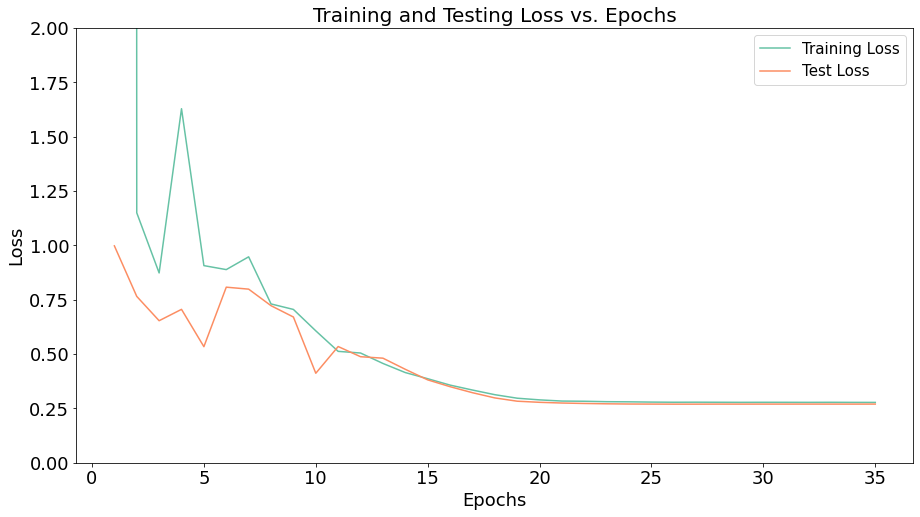

In [31]:
# Plot the losses
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(losses['train_loss'])+1), losses['train_loss'], label='Training Loss')
plt.plot(range(1, len(losses['test_loss'])+1), losses['test_loss'], label='Test Loss')
plt.ylim(0,2)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('Training and Testing Loss vs. Epochs', fontsize=20)
plt.legend(fontsize=15)
plt.show()

<a id='sec3.6'></a>
### [3.6. Creating a ResNet-based architecture model](#sec3.6)

We try another CNN architecture which is widely used and validated in medical imaging tasks.

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output channels are different, we need a projection layer for the skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the input (skip connection)
        return F.relu(out)

class PlaneCoordinatePredictorCNN(nn.Module):
    def __init__(self):
        super(PlaneCoordinatePredictorCNN, self).__init__()

        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)

        # Residual blocks
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        # Fully connected layer for regression
        self.fc = nn.Linear(512 * 7 * 7, 9)  # Assuming input images are 224x224

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))  # Initial convolutional layer
        out = F.max_pool2d(out, kernel_size=3, stride=2, padding=1)

        # Pass through the residual layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        # Flatten and pass through the fully connected layer
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

# Create the model
model = PlaneCoordinatePredictorCNN()

<a id='sec3.7'></a>
### [3.7. Training and testing a model](#sec3.7)

In [37]:
# Dictionary to store losses
losses = {'train_loss': [], 'test_loss': []}
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 50
loss_fn = nn.L1Loss()

In [38]:
# Train the model using DataLoader
train_model_with_dataloader(model, loss_fn, optimizer, train_loader, test_loader, epochs=epochs)

Epoch 1/50, Training Loss: 35.9162, Test Loss: 119140.9886
Epoch 2/50, Training Loss: 7.2090, Test Loss: 235.4610
Epoch 3/50, Training Loss: 3.5284, Test Loss: 1.3084
Epoch 4/50, Training Loss: 1.9153, Test Loss: 0.6119
Epoch 5/50, Training Loss: 1.2410, Test Loss: 0.7386
Epoch 6/50, Training Loss: 1.3214, Test Loss: 0.3832
Epoch 7/50, Training Loss: 1.0248, Test Loss: 0.4527
Epoch 8/50, Training Loss: 0.9026, Test Loss: 0.5087
Epoch 9/50, Training Loss: 0.8198, Test Loss: 0.5440
Epoch 10/50, Training Loss: 0.8429, Test Loss: 0.6226
Epoch 11/50, Training Loss: 0.8711, Test Loss: 0.5647
Epoch 12/50, Training Loss: 0.7651, Test Loss: 0.6833
Epoch 13/50, Training Loss: 0.6998, Test Loss: 0.4643
Epoch 14/50, Training Loss: 0.5362, Test Loss: 0.4071
Epoch 15/50, Training Loss: 0.6881, Test Loss: 0.9776
Epoch 16/50, Training Loss: 0.6429, Test Loss: 0.2487
Epoch 17/50, Training Loss: 0.4194, Test Loss: 1.2005
Epoch 18/50, Training Loss: 0.4053, Test Loss: 0.2082
Epoch 19/50, Training Loss: 0

<a id='sec3.8'></a>
### [3.8. Plot training and testing losses](#sec3.8)

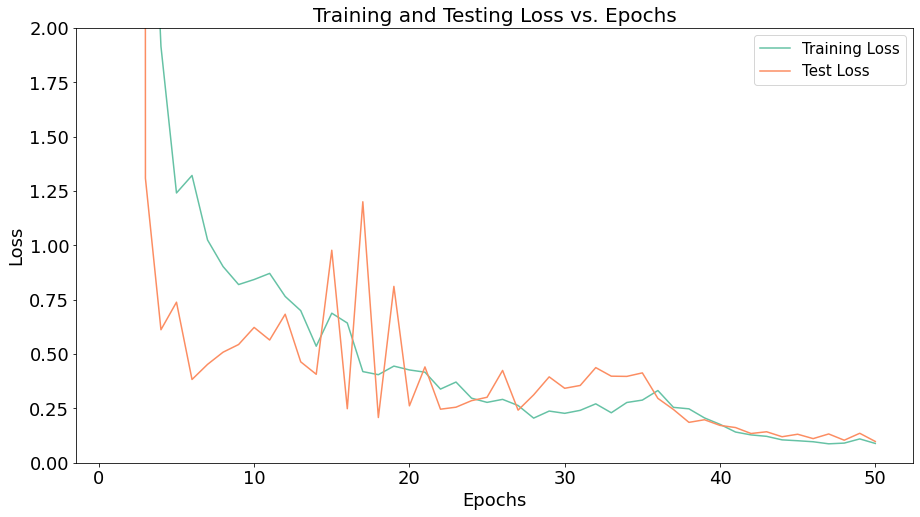

In [40]:
# Plot the losses
plt.figure(figsize=(15, 8))
plt.plot(range(1, len(losses['train_loss'])+1), losses['train_loss'], label='Training Loss')
plt.plot(range(1, len(losses['test_loss'])+1), losses['test_loss'], label='Test Loss')
plt.ylim(0,2)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title('Training and Testing Loss vs. Epochs', fontsize=20)
plt.legend(fontsize=15)
plt.show()

It can be shown that we get better results with the ResNet-based architecture model.

<a id="sec4"></a>
# [4. References](#sec4)

1. ScrapeHero. *Exploring Image Similarity Approaches in Python*. Medium. [https://medium.com/scrapehero/exploring-image-similarity-approaches-in-python-b8ca0a3ed5a3](https://medium.com/scrapehero/exploring-image-similarity-approaches-in-python-b8ca0a3ed5a3)

2. Kumar, A. *Similarity Functions in Python*. Medium. [https://ashukumar27.medium.com/similarity-functions-in-python-aa6dfe721035](https://ashukumar27.medium.com/similarity-functions-in-python-aa6dfe721035)

3. Okonji, O. *Cosine Similarity: Measuring Similarity Between Multiple Images*. Medium. [https://onyekaokonji.medium.com/cosine-similarity-measuring-similarity-between-multiple-images-f289aaf40c2b](https://onyekaokonji.medium.com/cosine-similarity-measuring-similarity-between


# End